In [143]:
import os
import sys
import argparse
import pickle
import math
import unicodedata
import pandas as pd
import numpy as np

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

from collections import defaultdict
from fuzzywuzzy import fuzz
from nltk.tokenize.treebank import TreebankWordTokenizer
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression

In [144]:
# arguments
data_path = 'gold-linking-data-df/'
train_path = os.path.join(data_path, "train-data.pkl")
valid_path = os.path.join(data_path, "valid-data.pkl")
test_path = os.path.join(data_path, "test-data.pkl")

train_df = pd.read_pickle(train_path)
valid_df = pd.read_pickle(valid_path)
# test_df = pd.read_pickle(test_path)

In [145]:
def get_questions(datapath):
    print("getting questions...")
    id2question = {}
    with open(datapath, 'r') as f:
        for line in f:
            items = line.strip().split("\t")
            lineid = items[0].strip()
            sub = items[1].strip()
            name = items[2].strip()
            pred = items[3].strip()
            obj = items[4].strip()
            question = items[5].strip()
            # print("{}   -   {}".format(lineid, question))
            id2question[lineid] = (sub, name, pred, question)
    return id2question

datapath = "../data/SimpleQuestions_v2_augmented/all.txt"
id2question = get_questions(datapath)
print(len(id2question))
print(id2question['valid-1'])

getting questions...
107808
('fb:m.0f3xg_', 'trump ocean club international hotel and tower', 'fb:symbols.namesake.named_after', 'who was the trump ocean club international hotel and tower named after')


       exact_name_match
count      10721.000000
mean         137.757112
std          734.444147
min            0.000000
25%            3.000000
50%            3.000000
75%            6.000000
max        11028.000000


{'boxes': [<matplotlib.lines.Line2D at 0x7f32ba3d0668>],
 'caps': [<matplotlib.lines.Line2D at 0x7f32ba3d6f60>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f32ba3e18d0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f32ba3d2a20>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f32ba3d0f98>,
  <matplotlib.lines.Line2D at 0x7f32ba3d67f0>]}

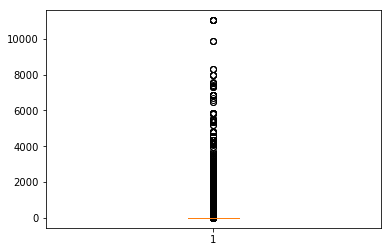

In [146]:
exact_match_counts = valid_df.groupby('lineid').agg({'exact_name_match': sum})
print(exact_match_counts.describe())
plt.boxplot(exact_match_counts['exact_name_match'])

In [110]:
X = valid_df[['idf', 'pques', 'squer']]
y = valid_df['true_label']

clf = LogisticRegression(C=0.1)
clf.fit(X, y)
print(clf.intercept_)
print(clf.coef_)

[-11.44033514]
[[ 0.6366524   2.90797542  2.17142816]]


In [147]:
data = []
df = valid_df
df['comb'] = 0.636*df['idf'] + 2.907*df['pques'] + 2.171*df['squer'] / 3.0
for sim in ['squer', 'pques', 'idf', 'comb']:
    print(sim)
    for hits in [1, 5, 20, 50, 100]:
#         print(hits)
        df = df.sort_values(by=['lineid', sim], ascending=[True, False])
        df_top_n = df.groupby('lineid').head(hits)
    #     print(df_top_n)
        df_line_stats = df_top_n.groupby('lineid').agg({'exact_name_match': sum, 'partial_name_match': sum, 'true_label': max})
    #     print(df_line_stats)

        total_lineids = len(set(df['lineid']))
        total_exact_match = df_line_stats['exact_name_match'].sum()
        total_partial_match = df_line_stats['partial_name_match'].sum()
        total_retrieved = df_line_stats['true_label'].sum()
        retrieval_rate = total_retrieved / total_lineids * 100.0
#         print("total_exact_match: {}".format(total_exact_match))
#         print("total_partial_match: {}".format(total_partial_match))
#         print("total_retrieved: {}".format(total_retrieved))
#         print("retrieval_rate: {}".format(retrieval_rate))
        row = [sim, hits, total_exact_match, total_partial_match, retrieval_rate]
        data.append(row)

results = pd.DataFrame(data)
results.columns = ["sim", "hits", "total_exact_match", "total_partial_match", "retrieval_rate"]
results

squer
pques
idf
comb


,sim,hits,total_exact_match,total_partial_match,retrieval_rate
0,squer,1,10591,52,74.200168
1,squer,5,32590,9017,88.023505
2,squer,20,59203,37291,92.323477
3,squer,50,92223,77454,94.310232
4,squer,100,134350,126173,95.793303
5,pques,1,10322,206,72.054846
6,pques,5,37261,4739,86.092715
7,pques,20,68240,29592,91.288126
8,pques,50,106241,67698,93.592016
9,pques,100,153168,117769,95.159034


In [35]:
valid_df_small = valid_df[['lineid', 'true_label', 'exact_name_match', 'partial_name_match', 'squer']]
hits = 5
valid_df_small.sort_values(['lineid','squer'],ascending=False)

,lineid,true_label,exact_name_match,partial_name_match,squer
1,valid-10845,1,1,0,1.0
5,valid-10845,1,1,0,1.0
6,valid-10845,0,1,0,1.0
7,valid-10845,1,1,0,1.0
8,valid-10845,1,1,0,1.0
9,valid-10845,1,1,0,1.0
16,valid-10845,1,1,0,1.0
26,valid-10845,1,1,0,1.0
27,valid-10845,1,1,0,1.0
28,valid-10845,1,1,0,1.0


In [24]:
def get_mids(df, hits):
    id2mids = defaultdict(list)
    
    return id2mids

def get_retrieval_rate(id2mids, id2question, hits, idspath):
    n_total = 0
    n_retrieved = 0
    lineids = open(idspath, 'r').read().splitlines()
    for lineid in lineids:
        n_total += 1
        truth_mid, truth_name, truth_rel, question = id2question[lineid]
        if not lineid in id2mids.keys():
            continue
        cand_mids = id2mids[lineid][:hits]
        if truth_mid in cand_mids:
            n_retrieved += 1
    return (n_retrieved / n_total) * 100.0

In [14]:
datasets = ['train', 'valid']
hits = [1, 5, 20, 50, 100]
for dataset in datasets:
    fpath = results_path + "{}-h100.txt".format(dataset)
    idspath = '../data/SimpleQuestions_v2_augmented/{}_lineids.txt'.format(dataset)
    for hit in hits:
        id2mids = get_mids(train_df, hit)
        retrieval = get_retrieval_rate(id2mids, id2question, hit, idspath)
        print("data: {}, hits: {}, retrieval: {}".format(dataset, hit, retrieval))

NameError: name 'results_path' is not defined